In [10]:
import numpy as np
from keras import layers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers, optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import Sequential
%matplotlib inline
import cv2
import os
import scipy
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.models import load_model

# Computing Train And Test Set Data Values 

In [ ]:
def load_images_from_folder(folder):    #Function is used to convert all the images in train and test set into 
    images = []                         #arrays of values of pixels of the corresponding image
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
final_images=[]

In [ ]:
train_images=[]         # Variable X_train contains the array of pixel values of all the images in Training Set
for l in range(1,37):
    images=load_images_from_folder("DevanagariHandwrittenCharacterDataset\Train\character_"+ str(l))
    train_images=train_images+images
    
for l in range(0,10):
    images=load_images_from_folder("DevanagariHandwrittenCharacterDataset\Train\digit_"+ str(l))
    train_images=train_images+images    
    
X_train=train_images    

In [18]:
y=[]                   # corressponding labels to the different classes of images in Training Set are saved in train_label (0-45)
for i in range(0,46):
    for j in range(0,1700):
        y.append(i)
Y=np.array(y)        
train_label=np.reshape(Y,(78200,1))
np.shape(train_label)

(78200, 1)

In [ ]:
test_images=[]          # Variable X_test contains the array of pixel values of all the images in Test Set
for l in range(1,37):
    images=load_images_from_folder("DevanagariHandwrittenCharacterDataset\Test\character_"+ str(l))
    test_images=test_images+images

for l in range(0,10):
    images=load_images_from_folder("DevanagariHandwrittenCharacterDataset\Test\digit_"+ str(l))
    test_images=test_images+images    

X_test=test_images     

In [19]:
y=[]                  # corressponding labels to the different classes of images in Test Set are saved in test_labels (0-45)    
for i in range(0,46):
    for j in range(0,300):
        y.append(i)
Y=np.array(y)        
test_label=np.reshape(Y,(13800,1))
np.shape(test_label)

(13800, 1)

In [ ]:
def one_hot_matrix(labels,C):       # This Function converts the labels into a One Hot Matrix i.e for label such as a=[0,1,2]
    C=tf.constant(C)                # the one hot matrix conversion of a would be = [[1,0,0],[0,1,0],[0,0,1]]
    _m=tf.one_hot(labels,C,axis=0)
    sess = tf.Session()
    _hot=sess.run(_m)
    sess.close()
    return _hot

In [ ]:
#Converting the corresponding Train Labels into their One Hot Matrix
Y_train_=one_hot_matrix(train_label,46).reshape(46,78200)
Y_test_=one_hot_matrix(test_label,46).reshape(46,13800)
Y_train=Y_train_.T
Y_test=Y_test_.T

In [ ]:
#all the dataset is then saved into its corressponding numpy file
np.save("X_train",X_train)
np.save("Y_train",Y_train)
np.save("X_test",X_test)
np.save("Y_test",Y_test)

In [2]:
# the saved data is loaded
X_train=np.load("X_train.npy")
Y_train=np.load("Y_train.npy")
X_test=np.load("X_test.npy")
Y_test=np.load("Y_test.npy")

In [3]:
print("X_train Shape = ",np.shape(X_train))
print("Y_train Shape = ",np.shape(Y_train))
print("X_test Shape = ",np.shape(X_test))
print("Y_test Shape = ",np.shape(Y_test))

X_train Shape =  (78200, 32, 32, 3)
Y_train Shape =  (78200, 46)
X_test Shape =  (13800, 32, 32, 3)
Y_test Shape =  (13800, 46)


# DESIN OF THE CONVOLUTIONAL NETWORK LAYERS

![title](convolution.jpeg)

In [ ]:
# Using Convolutional Neural Network
def Devnagri(input_shape):
    X_input=Input(input_shape)
    X=Conv2D(6,(5,5),strides=(1,1),name='conv0')(X_input)    
    X=BatchNormalization(axis=3,name='bn0')(X) # it reduces the covariate shift thus centering the dataset and reducing the computational load
    X=Activation('relu')(X) 
    X = MaxPooling2D((2, 2),strides=(2,2), name='max_pool_1')(X)
    X=Conv2D(16,(5,5),strides=(1,1),name='conv1')(X)
    X=BatchNormalization(axis=3,name='bn1')(X)
    X=Activation('relu')(X)
    X = MaxPooling2D((2, 2),strides=(2,2), name='max_pool_2')(X)
    X = Flatten()(X)
    X = Dense(46, activation='softmax', name='fc1',kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='Devnagri')
    return model

# COMPUTING THE DEVNAGRI MODEL WITH ADAM OPTIMIZATION

In [ ]:
devnagri_model=Devnagri(X_train.shape[1:])
devnagri_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
devnagri_model.fit(x = X_train, y = Y_train, epochs = 20,batch_size=32)

In [ ]:
#Saving the model learned
devnagri_model.save("devnagri_params.h5")

In [10]:
#loading the learned model
devnagri_model = load_model("devnagri_params.h5")

# ACCURACY ON THE TEST SET

In [13]:
preds = devnagri_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

13800/13800 [==============================] - 17s 1ms/step
Loss = 0.13500062845882987
Test Accuracy = 0.9660869565217391


In [31]:
#model summary
devnagri_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 6)         456       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 28, 28, 6)         24        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 10, 16)        2416      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 10, 10, 16)        64        
__________

# VERIFY THE CLASSIFIER 

[[2.09726339e-33 3.94538637e-38 1.67574948e-33 9.00184855e-22
  3.99659857e-17 1.37144449e-15 5.05174751e-18 3.30807054e-23
  0.00000000e+00 1.99991879e-32 3.23042681e-09 1.55283230e-19
  1.48386822e-17 4.58221489e-15 2.39896988e-35 8.52646395e-27
  1.67254693e-29 6.99944088e-17 3.66115748e-22 1.12013974e-29
  3.35689021e-20 1.34109784e-28 1.82190415e-26 6.76518200e-37
  0.00000000e+00 1.98500786e-23 1.01015197e-16 2.59925048e-30
  6.80600977e-20 2.70462856e-30 2.63097321e-30 3.97689261e-30
  1.56801807e-14 7.19921359e-31 3.94004792e-30 1.47305921e-36
  2.23820162e-13 1.08937690e-22 1.70823201e-20 1.56700491e-21
  1.46890596e-22 3.35217105e-26 7.69993533e-19 6.05939719e-20
  1.00000000e+00 5.58290510e-19]]
44
The Image loaded is =  8


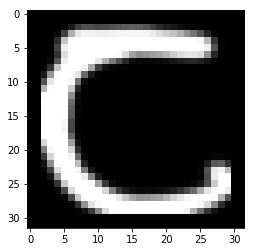

In [24]:
#ENTER THE NAME OF THE IMAGE IN THE FILE ADDRESS TO DISPLAY THE RESULT
img = image.load_img('8.png', target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
imshow(img)
Prediction={0:'ka',1:'kha',2:'ga',3:'gha',4:'kna',5:'cha',6:'chha',7:'ja',8:'jha',9:'yna',10:'taamatar',11:'thaa',12:'daa',13:'dhaa',14:'adna',15:'tabala',16:'tha',17:'da',18:'dha',19:'na',20:'pa',21:'pha',22:'ba',23:'bha',24:'ma',25:'yaw',26:'ra',27:'la',28:'waw',29:'motosaw',30:'petchiryakha',31:'patalosaw',32:'ha',33:'chhya',34:'tra',35:'gya',36:'0',37:'1',38:'2',39:'3',40:'4',41:'5',42:'6',43:'7',44:'8',45:'9'}
print((devnagri_model.predict(x)))
print(np.argmax(devnagri_model.predict(x)))
a=np.argmax(devnagri_model.predict(x))
print('The Image loaded is = ',Prediction[a])